In [107]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from torchtext.data.utils import get_tokenizer
from torchtext.vocab import build_vocab_from_iterator
import torchtext
import re
import string
import tqdm
import matplotlib.pyplot as plt
# https://github.com/rsreetech/PyTorchTextClassificationCustomDataset/blob/main/PyTorchTweetTextClassification.ipynb

from torcheval.metrics import BinaryAccuracy


In [108]:
devise = "cpu"

In [109]:
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from nltk.tokenize import TweetTokenizer


def process_tweet(tweet):
    '''
    Input:
        tweet: a string containing a tweet
    Output:
        tweets_clean: a list of words containing the processed tweet

    '''
    stemmer = PorterStemmer()
    stopwords_english = stopwords.words('english')
    # remove stock market tickers like $GE
    tweet = re.sub(r'\$\w*', '', tweet)
    # remove old style retweet text "RT"
    tweet = re.sub(r'^RT[\s]+', '', tweet)
    # remove hyperlinks
    #tweet = re.sub(r'https?:\/\/.*[\r\n]*', '', tweet)
    tweet = re.sub(r'https?://[^\s\n\r]+', '', tweet)
    # remove hashtags
    # only removing the hash # sign from the word
    tweet = re.sub(r'#', '', tweet)
    # tokenize tweets
    tokenizer = TweetTokenizer(preserve_case=False, strip_handles=True,
                               reduce_len=True)
    tweet_tokens = tokenizer.tokenize(tweet)

    tweets_clean = []
    for word in tweet_tokens:
        if (word not in stopwords_english and  # remove stopwords
            word not in string.punctuation):  # remove punctuation
            # tweets_clean.append(word)
            stem_word = stemmer.stem(word)  # stemming word
            tweets_clean.append(stem_word)

    return tweets_clean

In [110]:
process_tweet("hello how do you taisty")

['hello', 'taisti']

In [111]:
# def remove_url(text): 
#     url_pattern  = re.compile('http[s]?://(?:[a-zA-Z]|[0-9]|[$-_@.&+]|[!*\(\),]|(?:%[0-9a-fA-F][0-9a-fA-F]))+')
#     return url_pattern.sub(r'', text)

# def remove_emoji(text):
#     emoji_pattern = re.compile("["
#                            u"\U0001F600-\U0001F64F"  # emoticons
#                            u"\U0001F300-\U0001F5FF"  # symbols & pictographs
#                            u"\U0001F680-\U0001F6FF"  # transport & map symbols
#                            u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
#                            u"\U00002702-\U000027B0"
#                            u"\U000024C2-\U0001F251"
#                            "]+", flags=re.UNICODE)
#     return emoji_pattern.sub(r'', text)

# def clean_text(text ): 
#     delete_dict = {sp_character: '' for sp_character in string.punctuation} 
#     delete_dict[' '] = ' ' 
#     table = str.maketrans(delete_dict)
#     text1 = text.translate(table)
#     textArr= text1.split()
#     text2 = ' '.join([w for w in textArr if ( not w.isdigit() and  ( not w.isdigit() and len(w)>2))]) 
    
#     return text2.lower()

# Dataset

In [112]:
class MyDataset(Dataset):
    def __init__(self, data, name="dataset") -> None:
        super().__init__()
        self.name = name
        text, target = data
        self.text = np.array(text)
        self.n_samples = len(self.text)
        if target:
            self.target = np.array(target)
        else:
            self.target = (-1) * np.ones(self.n_samples, dtype=np.int32)

    def __getitem__(self, index):
        return (self.text[index], self.target[index])
    
    def __len__(self):
        return self.n_samples
    
    def get_stats(self):
        print('--------------------')
        print(self.name)
        for val, nb in np.array(np.unique(self.target , return_counts=True)).T:
            print(f"{val}   {nb}")
        print('--------------------')


In [113]:
def splitTrainVal(path, valid_size):
    df = pd.read_csv(path)
    df.drop(columns=["id", "keyword", "location"], inplace=True)
    # df["text"] = df["text"].apply(remove_url)
    # df["text"] = df["text"].apply(remove_emoji)
    # df["text"] = df["text"].apply(clean_text)

    (X_train, X_valid,
        Y_train, Y_valid) = train_test_split(df['text'].to_list(),
                                            df['target'].to_list(),
                                            test_size=valid_size,
                                            shuffle=True,
                                            stratify = df['target'].to_list(),
                                            random_state=0)
    return (X_train, X_valid, Y_train, Y_valid)

In [114]:
# Train et Val
X_train, X_valid, Y_train, Y_valid = splitTrainVal("data/train.csv", 0.2)
train_dataset = MyDataset((X_train, Y_train), name="Train")
val_dataset = MyDataset((X_valid, Y_valid), name="Val")

# Test
df_test = pd.read_csv("data/test.csv")
df_test.drop(columns=["id", "keyword", "location"], inplace=True)
# df_test["text"] = df_test["text"].apply(remove_url)
# df_test["text"] = df_test["text"].apply(remove_emoji)
# df_test["text"] = df_test["text"].apply(clean_text)
test_dataset = MyDataset((df_test["text"].to_list(), None), name="Test")


In [115]:
train_dataset.get_stats()
val_dataset.get_stats()
test_dataset.get_stats()

--------------------
Train
0   3473
1   2617
--------------------
--------------------
Val
0   869
1   654
--------------------
--------------------
Test
-1   3263
--------------------


# Tokenisation

In [118]:
# tokenizer = get_tokenizer('basic_english')

def yield_tokens(data_iter):
    for text, _ in data_iter:
        yield process_tweet(text)

vocab = build_vocab_from_iterator(yield_tokens(train_dataset), specials=["<unk>"])
vocab.set_default_index(vocab["<unk>"])

text_pipeline = lambda x: vocab(process_tweet(x))
label_pipeline = lambda x: int(x)

In [119]:
len(vocab)

10972

Le vocabulaire est trop grand. Besoin de plus adapter les phrases. Retirer les stop word, prendre la racine ===> Voir comment ca a ete fait dans les premiers days de formation NPL

In [120]:
def tokeniseDataset(sentenses, tokenizer):
    return [tokenizer(sentense) for sentense in sentenses]


def getMaxLenTweet(sentenses, tokenizer):
    text_tokenised = tokeniseDataset(sentenses, tokenizer)
    return max(len(txt) for txt in text_tokenised)


def transformSenToIntMat(sentenses, tokenizer, vocab, max_num_token):
    text_tokenised = tokeniseDataset(sentenses, tokenizer)
    vocab_list = [vocab(text) for text in text_tokenised]
    return np.array([sous_liste + [0] * (max_num_token - len(sous_liste)) for sous_liste in vocab_list], dtype=np.int32)

In [121]:
# Get the size of the input feature vector 
nb_features = max(
    getMaxLenTweet(train_dataset.text, process_tweet),
    getMaxLenTweet(val_dataset.text, process_tweet),
    getMaxLenTweet(test_dataset.text, process_tweet))

print(f"Our data set (train and test) has {nb_features} tokens max. This will be the shape of the text vector")

Our data set (train and test) has 29 tokens max. This will be the shape of the text vector


# Dataloader

In [12]:
def collate_batch(batch): # batch est une list de tuple Text label
    sentenses = [elem[0] for elem in batch]
    sentenses_mat = torch.from_numpy(transformSenToIntMat(sentenses, process_tweet, vocab, nb_features))
    label = torch.from_numpy(np.array([elem[1] for elem in batch]).reshape(len(sentenses), 1))
    return sentenses_mat, label

In [13]:
dataloader = DataLoader(dataset=train_dataset, batch_size=32, shuffle=True, collate_fn=collate_batch)

In [14]:
val_dataloader = DataLoader(dataset=val_dataset, batch_size=32, shuffle=True, collate_fn=collate_batch)

# Model

In [89]:
class MyModel(nn.Module):
    def __init__(self, vocab_size, hidden_size=8, embedding_size=32, num_layers=1, dense_dim=16, num_class=1):
        super(MyModel, self).__init__()
        self.vocab_size = vocab_size
        self.hidden_size = hidden_size
        self.embedding_size = embedding_size
        self.num_layers = num_layers
        self.dense_dim = dense_dim
        self.num_class = num_class
        self.embedding = nn.Embedding(vocab_size, embedding_size)
        self.rnn = nn.RNN(embedding_size, hidden_size, num_layers, batch_first=True) #batch first = True veut dire que la shape de l'input est (batch_size, seq, input_size)
        # self.dense1 = nn.Linear(hidden_size, dense_dim)
        self.dense2 = nn.Linear(hidden_size, num_class)

    def forward(self,x, h_0=None):
        """
        Run the forward pass

        Parameters : 
            x : torch.tensor. Shape (n_sample, input_size)
            h_0 : torch.tensor ou None.
                Initial Hidden state of the RRN.
        Return : 
            output : torch.tensor (batch size, Sequence Lenght, hidden_size)
            h_n : torch.tensor final hidden state for each element in the batch
        """
        emb = self.embedding(x)
        if h_0 is not None:
            _, h = self.rnn(emb, h_0)
        else:
            _, h = self.rnn(emb)
        h_mean = h.mean(dim=0)
        # result_dense1 = nn.functional.sigmoid(self.dense1(h_mean))
        result_final = nn.functional.sigmoid(self.dense2(h_mean))
        return result_final


def compute_loss(loss, model, dataloader):
    """Compute average loss over a dataset"""
    model.eval()
    all_losses = []
    for X_batch, y_batch in dataloader:
        probs = model(X_batch)
        # print(probs.shape)
        y_batch = y_batch.type(torch.float32)
        # y_batch = nn.functional.one_hot(y_batch.squeeze().long(), num_classes=2).float()
        all_losses.append(loss(probs, y_batch).item())
    return np.mean(all_losses)

In [90]:
model = MyModel(len(vocab))

In [91]:
loss_fn = nn.BCELoss()
metric = BinaryAccuracy()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
n_epochs = 100

In [92]:
compute_loss(loss_fn, model, dataloader)

0.6902874495970641

In [93]:
def calculate_acc(metric, model, dataloader):
    model.eval()
    true = []
    total_num = []
    for X_batch, y_batch in dataloader:
        probs = model(X_batch)
        y_hat = torch.argmax(probs, dim=1)
        y_batch = torch.reshape(y_batch, (y_batch.shape[0],))
        test = y_hat == y_batch
        true.append(sum(test))
        total_num.append(len(y_batch))
    acc = (sum(true) / sum(total_num)) * 100
    return acc


In [94]:
train_loss_history = []
val_loss_history = []
acc_train_history = []
acc_val_history = []


In [95]:
for epoch in range(n_epochs):
    model.train()
    for  idx, ( X_batch, y_batch) in enumerate(dataloader):
        optimizer.zero_grad()
        probs = model(X_batch)
        y_batch = y_batch.type(torch.float32)
        loss = loss_fn(probs, y_batch)
        loss.backward()
        optimizer.step()
    train_loss = compute_loss(loss_fn, model, dataloader)
    val_los = compute_loss(loss_fn, model, val_dataloader)
    acc_train = calculate_acc(metric, model, dataloader)
    acc_val = calculate_acc(metric, model, val_dataloader)
    train_loss_history.append(train_loss)
    val_loss_history.append(val_los)
    acc_train_history.append(acc_train)
    acc_val_history.append(acc_val)
    print(f"Epoch: {epoch}, {train_loss=:.6f}, {val_los=:.6f}, {acc_train=:.6f}, {acc_val=:.6f} ")

Epoch: 0, train_loss=0.683341, val_los=0.682815, acc_train=57.027912, acc_val=57.058437 
Epoch: 1, train_loss=0.683309, val_los=0.683772, acc_train=57.027912, acc_val=57.058437 
Epoch: 2, train_loss=0.683692, val_los=0.684087, acc_train=57.027912, acc_val=57.058437 
Epoch: 3, train_loss=0.683209, val_los=0.683515, acc_train=57.027912, acc_val=57.058437 
Epoch: 4, train_loss=0.684048, val_los=0.684601, acc_train=57.027912, acc_val=57.058437 
Epoch: 5, train_loss=0.683992, val_los=0.683765, acc_train=57.027912, acc_val=57.058437 
Epoch: 6, train_loss=0.683567, val_los=0.684357, acc_train=57.027912, acc_val=57.058437 
Epoch: 7, train_loss=0.683107, val_los=0.682883, acc_train=57.027912, acc_val=57.058437 
Epoch: 8, train_loss=0.683472, val_los=0.683711, acc_train=57.027912, acc_val=57.058437 
Epoch: 9, train_loss=0.683347, val_los=0.683402, acc_train=57.027912, acc_val=57.058437 
Epoch: 10, train_loss=0.683304, val_los=0.683122, acc_train=57.027912, acc_val=57.058437 
Epoch: 11, train_los

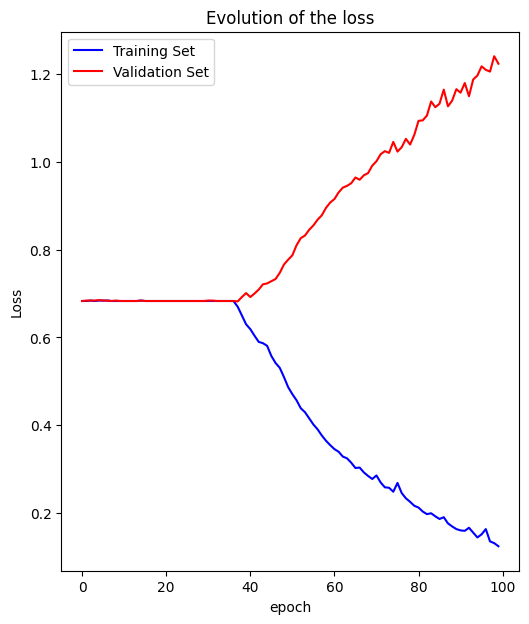

In [96]:
x = range(len(train_loss_history))
train_loss_history_round = np.round(train_loss_history, 3)
val_loss_history_round = np.round(val_loss_history, 3)

plt.figure(figsize=(13, 7))
plt.subplot(1, 2, 1)
plt.plot(x, train_loss_history_round, "b", label="Training Set")
plt.plot(x, val_loss_history_round, "r", label="Validation Set")
plt.xlabel("epoch")
plt.ylabel("Loss")
plt.legend()
plt.title(f"Evolution of the loss")
plt.show()

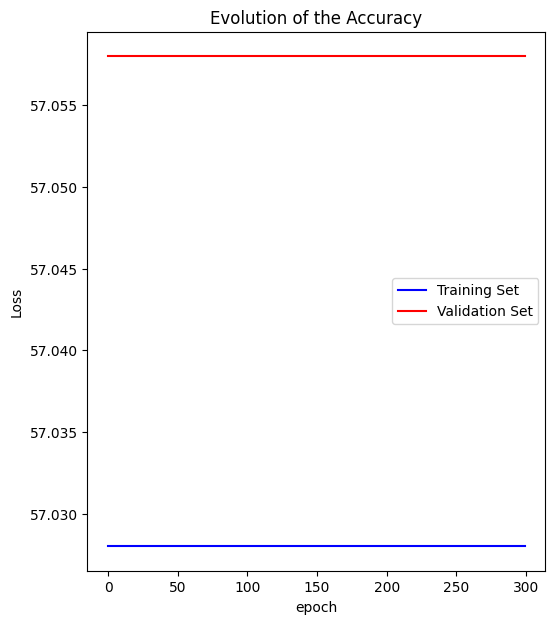

In [86]:
x = range(len(train_loss_history))
acc_train_history_round = np.round(acc_train_history, 3)
acc_val_history_round = np.round(acc_val_history, 3)

plt.figure(figsize=(13, 7))
plt.subplot(1, 2, 1)
plt.plot(x, acc_train_history_round, "b", label="Training Set")
plt.plot(x, acc_val_history_round, "r", label="Validation Set")
plt.xlabel("epoch")
plt.ylabel("Loss")
plt.legend()
plt.title(f"Evolution of the Accuracy")
plt.show()

# Saving the model

In [87]:
torch.save(model, "model.pth")